<a href="https://colab.research.google.com/github/Aaricis/AI-Expert-Roadmap/blob/main/HW12/ML2022__hw12_reinforcement_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 思路
助教发布作业时，Colab的Python版本为3.9，笔者做作业的当下Colab的Python版本已升级为3.11。原先的依赖版本已经不能在Python 3.11环境使用，笔者升级依赖版本，重新配置了运行环境。因此，环境实际Baseline已与助教当时提供的不同，助教Baseline不具有参考意义。

出于学习的目的，下面仅根据助教的提示，实现各个Baseline对应的trick，重点关注score的相对提升，不关注具体的值。



## Simple Baseline (Score: [0, 110])
Your final reward is : 75.46

跑通Sample Code

```python
NUM_BATCH = 1000
```




## Medium Baseline (Score: [110, 180])

Your final reward is : 156.89


- 设置NUM_BATCH;

```python
NUM_BATCH = 500
```

- 将reward计算方式改为discounted reward;

删除原本使用的Immediate Reward:


```python
# rewards.append(reward)
```

改成Discounted Reward:


```python
if done:
    final_rewards.append(reward)
    total_rewards.append(total_reward)

    T = len(seq_rewards)  # total steps
    gamma = 0.99
    discounted_rewards = [0] * T  # initialize the rewards

    # calculated backwards
    cumulative = 0
    for t in reversed(range(T)):
        cumulative = seq_rewards[t] + gamma * cumulative
        discounted_rewards[t] = cumulative

    rewards += discounted_rewards
    break
```

## Strong Baseline (Score: [180, 275])

Your final reward is : 232.88

### Actor-Critic

Actor-Critic算法是强化学习中的一种混合框架，结合了策略梯度（Actor）和值函数估计（Critic）的优势，既能直接优化策略，又能通过值函数减少训练方差。

- Actor（策略网络）：负责生成动作的策略函数$\pi(a|s;\theta)$，直接控制智能体行为，告诉智能体当前状态下应做什么动作。
  - 输入：状态$s$；
  - 输出：动作概率分布（离散）或动作均值/方差（连续）。
- Critic（值函数网络）：估计当前策略的“未来回报”，指导 Actor 改善。
  - 输入：状态$s$；
  - 输出：标量价值估计。
- 协同机制：Actor根据Critic的评价调整策略，Crtic通过TD误差优化价值估计。

### 训练流程
1. 采样交互：
  
  与环境交互，得到$(s_t, a_t, r_t, s_{t+1})$;
2. 计算TD误差或Advantage:
  
  使用Critic来评估当前策略的表现，两种方式：
  - TD-error（Temporal Difference）：
    $$
    \delta = r_t + \gamma V(s_{t+1}) - V(s_t)
    $$
  - Advantage（优势函数）：
    $$
    A(s_t, a_t) = Q(s_t, a_t) - V(s_t) \approx \delta
    $$
3. 更新Critic（值函数）：
  
  使用TD误差训练Critic的参数，最小化：
  $$
  L_{critic} = (r_t + \gamma V(s_{t+1}) - V(s_t))^2
  $$
4. 更新Actor（策略网络）：
  
  使用策略梯度，最大化优势：
  $$
  L_{actor} = -log\pi(a_t|s_t;\theta) \cdot A(s_t, a_t)
  $$

### 代码实现
#### Actor
```pyhton
class Actor(nn.Module):
  def __init__(self, state_size=8, action_size=4, hidden_size=64):
    super().__init__()
    self.fc = nn.Sequential(
        nn.Linear(state_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, action_size),
        nn.Softmax(dim=-1)
    )

  def forward(self, state):
    # Returing probability of each action
    return self.fc(state)

```

#### Critic
```python
class Critic(nn.Module):
  def __init__(self, state_size=8, hidden_size=64, drop_prob=0.3):
    super().__init__()
    self.fc = nn.Sequential(
        nn.Linear(state_size, hidden_size),
        nn.ReLU(),
        nn.Dropout(p=drop_prob),
        nn.Linear(hidden_size, hidden_size // 2),
        nn.ReLU(),
        nn.Dropout(p=drop_prob),
        nn.Linear(hidden_size // 2, 1)
    )

  def forward(self, state):
    # critic: evaluates being in the state s_t
    return self.fc(state)
```
#### Actor Critic Agent
```python
from torch.optim.lr_scheduler import StepLR
from argparse import Namespace

class ActorCriticAgent():
  def __init__(self, actor, critic, **kwargs):
    # Configuration parameters
    self.config = Namespace(**kwargs)

    # Actor-Critic Network
    self.actor = actor
    self.critic = critic
    self.optimizer_actor = getattr(optim, self.config.optimizer)(self.actor.parameters(), lr=self.config.learning_rate)
    self.optimizer_critic = getattr(optim, self.config.optimizer)(self.critic.parameters(), lr=self.config.learning_rate)
    self.loss_fn = nn.SmoothL1Loss()

    # Step and update frequency
    self.step_t = 0
    self.update_freq = self.config.update_freq

    # Records
    self.loss_values = []

    self.empty()

  def step(self, log_probs, rewards, state_values, next_state_values, dones):
    self.step_t = (self.step_t + 1) % self.update_freq

    # Append the experiences
    self.rewards += rewards
    self.log_probs += log_probs
    self.state_values += state_values
    self.next_state_values += next_state_values
    self.dones += dones

    # Update Network
    if self.step_t == 0:
      self.learn(
          torch.stack(self.log_probs),  # log probabilities
          torch.tensor(self.rewards, dtype=torch.float32),  # discounted cumulative rewards
          torch.tensor(self.state_values, requires_grad=True),  # state_values
          torch.tensor(self.next_state_values, requires_grad=True), # next_state_values
          torch.tensor(self.dones, dtype=torch.float32) # dones
      )

      # Empty the experiences
      self.empty()

  def empty(self):
      """
      Empty the experience list
      """
      self.rewards = []
      self.log_probs = []
      self.state_values = []
      self.next_state_values = []
      self.dones = []

  def learn(self, log_probs, rewards, state_values, next_state_values, dones):
    """
    Update value parameters using given experience list.

    Arguments:
      log_probs (torch.Tensor): log probabilities
      rewards (torch.Tensor): discounted cumulative rewards
      state_values (torch.Tensor): predicted current state_values
      next_state_values (torch.Tensor): predicted next state_values
      dones (torch.Tensor): dones

    """
    state_values = state_values.squeeze()
    next_state_values = next_state_values.squeeze()

    gamma = 0.99
    advantages = rewards + gamma * next_state_values * (1 - dones) - state_values

    # Normalization
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-9)

    # Calculate loss
    loss_actor = (-log_probs * advantages).sum()
    loss_critic = self.loss_fn(state_values, rewards)
    self.loss_values.append(loss_actor.detach().item() + loss_critic.detach().item())

    # Backpropagation
    self.optimizer_actor.zero_grad()
    self.optimizer_critic.zero_grad()
    loss_actor.backward()
    loss_critic.backward()
    self.optimizer_actor.step()
    self.optimizer_critic.step()

  def sample(self, state):
    """
    Return action, log_prob, state_value for given state.

    Arguments:
      state(array_like): current state
    """
    action_prob = self.actor(torch.FloatTensor(state))
    state_value = self.critic(torch.FloatTensor(state))

    action_dist = Categorical(action_prob)
    action = action_dist.sample()
    log_prob = action_dist.log_prob(action)
    return action.item(), log_prob, state_value
```



## Boss Baseline (Score: [275, inf))
Your final reward is : 291.98

### Deep Q-Network (DQN)
LunarLander任务的动作空间是离散的，并且DQN非常适合离散动作的环境，因此实作中选择DQN算法训练LunarLander任务。

Deep Q-Network(DQN)是深度强化学习(DRL)中的一种经典算法，由DeepMind在2013年提出。核心思想是用神经网络近似Q值函数，解决了传统Q-Learning在高维状态空间下的局限性。

1. Q-Learning简述

Q-Learning的目标是学习状态-动作值函数$Q(s, a)$，表示在状态$s$采取动作$a$后的预期回报。更新公式如下：
$$
Q(s_t, a_t) ← Q(s_t, a_t) + \alpha (r_t + \gamma \mathop{\max}\limits_{a^{\prime}} Q(s_{t+1}, a^{\prime}) - Q(s_t, a_t))
$$

2. Deep Q-Network（DQN）核心思想

DQN使用一个神经网络来逼近Q函数：
$$
Q(s, a; \theta) \approx Q^{*}(s, a)
$$
- 输入：当前状态$s$；
- 输出：每个可能动作的Q值$Q(s, a)$；

- 目标：最小化Bellman残差：
$$
L(\theta) = (r + \gamma \mathop{\max}\limits_{a^{\prime}} Q(s^{\prime}, a^{\prime}; \theta^{-}) - Q(s, a; \theta))^2
$$
其中$\theta^{-}$是目标网络的参数，是$\theta$的一个延迟副本。

3. 核心机制
DQN的核心机制有：
- 经验回放（Experience Replay）
- 目标网络（Target Network）
- $\epsilon - Greedy$策略

详情参考原始论文[Playing Atari with Deep Reinforcement Learning](https://arxiv.org/abs/1312.5602)

### 代码实现
DQN是经典的深度强化学习算法，有标准的库可供调用，不必重复造轮子。实作调用Stable-Baselines3库的DQN实现。
#### 导入库

```python
!pip install stable-baselines3[extra]
```
#### 训练
```python
from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.utils import get_schedule_fn

# 定义学习率调度（从 1e-3 线性衰减到 1e-5）
lr_schedule = get_schedule_fn(
    lambda progress: 1e-3 * (1 - progress) + 1e-5 * progress
)

model = DQN(
    "MlpPolicy",
    env,
    learning_rate=lr_schedule(0.0),
    buffer_size=500_000,
    learning_starts=10_000,
    batch_size=64,
    tau=1.0,
    gamma=0.99,
    train_freq=4,
    target_update_interval=5_000,
    exploration_fraction=0.2,        # 20% 步骤用于探索
    exploration_final_eps=0.05,
    policy_kwargs=dict(net_arch=[256, 256]),
    verbose=1,
)

# 训练前评估初始随机策略
mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=10)
print(f"初始平均奖励: {mean_reward:.2f}")

# 训练
model.learn(total_timesteps=2_000_000)

# 评估
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=20)
print(f"✅ Evaluation over 20 episodes: mean reward = {mean_reward:.2f} ± {std_reward:.2f}")

# 保存模型
model.save("dqn_lunarlander_best")

```
#### 测试

```python
# For DQN
fix(env, seed)

del model # remove to demonstrate saving and loading
# 加载模型
model = DQN.load("dqn_lunarlander_best")

NUM_OF_TEST = 5 # Do not revise this !!!
test_total_reward = []
action_list = []


for i in range(NUM_OF_TEST):
  actions = []
  state, _ = env.reset()

  img = plt.imshow(env.render())

  total_reward = 0

  done = False
  while not done:
      action, _states = model.predict(state, deterministic=True)
      actions.append(action.item())
      # state, reward, done, _ = env.step(action)
      state, reward, terminated, truncated, info = env.step(action)
      done = terminated or truncated

      total_reward += reward

      img.set_data(env.render())
      display.display(plt.gcf())
      display.clear_output(wait=True)

  print(total_reward)
  test_total_reward.append(total_reward)

  action_list.append(actions) # save the result of testing
```




# **Homework 12 - Reinforcement Learning**

If you have any problem, e-mail us at mlta-2023-spring@googlegroups.com



## Preliminary work

First, we need to install all necessary packages.
One of them, gym, builded by OpenAI, is a toolkit for developing Reinforcement Learning algorithm. Other packages are for visualization in colab.

In [ ]:
# For Python 3.11
# Step 0: 清理已有的 gym 和 box2d 避免冲突
!pip uninstall -y gym gymnasium box2d box2d-py swig_box2d

# Step 1: 安装 C++ 依赖
!apt update -y
!apt install -y swig cmake libbox2d-dev

# Step 2: 安装 Python 包
!pip install gymnasium[box2d] pygame opencv-python-headless
!pip install PyVirtualDisplay


Found existing installation: gym 0.25.2
Uninstalling gym-0.25.2:
  Successfully uninstalled gym-0.25.2
Found existing installation: gymnasium 1.1.1
Uninstalling gymnasium-1.1.1:
  Successfully uninstalled gymnasium-1.1.1
Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:11 http

In [ ]:
# 测试代码（运行环境是否成功）
import gymnasium as gym

env = gym.make("LunarLander-v3", render_mode="rgb_array")
obs, info = env.reset()
done = False
while not done:
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
env.close()

print("✅ LunarLander-v2 ran successfully.")


✅ LunarLander-v2 ran successfully.


In [ ]:
# 助教原本安装环境
# !apt update
# !apt install python-opengl xvfb -y
# !pip install -q swig
# !pip install box2d==2.3.2 gym[box2d]==0.25.2 box2d-py pyvirtualdisplay tqdm numpy==1.22.4
# !pip install box2d==2.3.2 box2d-kengz
# !pip freeze > requirements.txt



Next, set up virtual display，and import all necessaary packages.

In [ ]:
%%capture
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

%matplotlib inline
import matplotlib.pyplot as plt

from IPython import display

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm.notebook import tqdm

# Warning ! Do not revise random seed !!!
# Your submission on JudgeBoi will not reproduce your result !!!
Make your HW result to be reproducible.


In [ ]:
seed = 2023 # Do not change this
def fix(env, seed):
  # env.seed(seed)
  env.reset(seed=seed)
  env.action_space.seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
      torch.cuda.manual_seed_all(seed)

Last, call gym and build an [Lunar Lander](https://gym.openai.com/envs/LunarLander-v2/) environment.

In [ ]:
%%capture
# import gym
import random
env = gym.make("LunarLander-v3", render_mode="rgb_array")
fix(env, seed) # fix the environment Do not revise this !!!

## What Lunar Lander？

“LunarLander-v2”is to simulate the situation when the craft lands on the surface of the moon.

This task is to enable the craft to land "safely" at the pad between the two yellow flags.
> Landing pad is always at coordinates (0,0).
> Coordinates are the first two numbers in state vector.

![](https://gym.openai.com/assets/docs/aeloop-138c89d44114492fd02822303e6b4b07213010bb14ca5856d2d49d6b62d88e53.svg)

"LunarLander-v2" actually includes "Agent" and "Environment".

In this homework, we will utilize the function `step()` to control the action of "Agent".

Then `step()` will return the observation/state and reward given by the "Environment".

### Observation / State

First, we can take a look at what an Observation / State looks like.

In [ ]:
print(env.observation_space)

Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)



`Box(8,)`means that observation is an 8-dim vector
### Action

Actions can be taken by looks like

In [ ]:
print(env.action_space)

Discrete(4)


`Discrete(4)` implies that there are four kinds of actions can be taken by agent.
- 0 implies the agent will not take any actions
- 2 implies the agent will accelerate downward
- 1, 3 implies the agent will accelerate left and right

Next, we will try to make the agent interact with the environment.
Before taking any actions, we recommend to call `reset()` function to reset the environment. Also, this function will return the initial state of the environment.

In [ ]:
initial_state = env.reset()
print(initial_state)

(array([-0.00552921,  1.4196991 , -0.5600674 ,  0.3901667 ,  0.00641378,
        0.12686351,  0.        ,  0.        ], dtype=float32), {})


Then, we try to get a random action from the agent's action space.

In [ ]:
random_action = env.action_space.sample()
print(random_action)

1


More, we can utilize `step()` to make agent act according to the randomly-selected `random_action`.
The `step()` function will return four values:
- observation / state
- reward
- done (True/ False)
- Other information

In [ ]:
# observation, reward, done, info = env.step(random_action)
observation, reward, terminated, truncated, info = env.step(random_action)
done = terminated or truncated

In [ ]:
print(done)

False


### Reward


> Landing pad is always at coordinates (0,0). Coordinates are the first two numbers in state vector. Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points. If lander moves away from landing pad it loses reward back. Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. Each leg ground contact is +10. Firing main engine is -0.3 points each frame. Solved is 200 points.

In [ ]:
print(reward)

-0.8266717815513107


### Random Agent
In the end, before we start training, we can see whether a random agent can successfully land the moon or not.

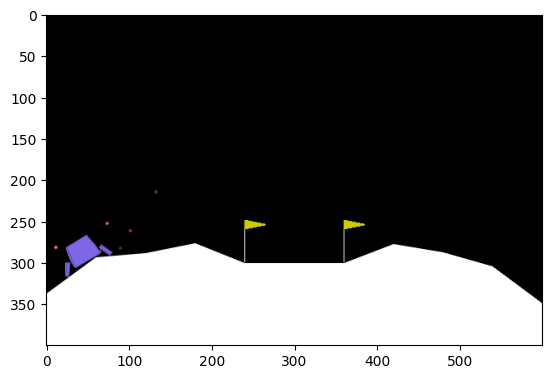

In [ ]:
env.reset()

# img = plt.imshow(env.render(mode='rgb_array'))
img = plt.imshow(env.render())

done = False
while not done:
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    # observation, reward, done, _ = env.step(action)

    img.set_data(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)

## Policy Gradient
Now, we can build a simple policy network. The network will return one of action in the action space.

In [ ]:
class PolicyGradientNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(8, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 4)

    def forward(self, state):
        hid = torch.tanh(self.fc1(state))
        hid = torch.tanh(hid)
        return F.softmax(self.fc3(hid), dim=-1)

Then, we need to build a simple agent. The agent will acts according to the output of the policy network above. There are a few things can be done by agent:
- `learn()`：update the policy network from log probabilities and rewards.
- `sample()`：After receiving observation from the environment, utilize policy network to tell which action to take. The return values of this function includes action and log probabilities.

In [ ]:
from torch.optim.lr_scheduler import StepLR
class PolicyGradientAgent():

    def __init__(self, network):
        self.network = network
        self.optimizer = optim.SGD(self.network.parameters(), lr=0.002)

    def forward(self, state):
        return self.network(state)
    def learn(self, log_probs, rewards):
        loss = (-log_probs * rewards).sum() # You don't need to revise this to pass simple baseline (but you can)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def sample(self, state):
        action_prob = self.network(torch.FloatTensor(state))
        action_dist = Categorical(action_prob)
        action = action_dist.sample()
        log_prob = action_dist.log_prob(action)
        return action.item(), log_prob

Lastly, build a network and agent to start training.

In [ ]:
network = PolicyGradientNetwork()
agent = PolicyGradientAgent(network)

## Training Agent

Now let's start to train our agent.
Through taking all the interactions between agent and environment as training data, the policy network can learn from all these attempts,

In [ ]:
agent.network.train()  # Switch network into training mode
EPISODE_PER_BATCH = 5  # update the  agent every 5 episode
NUM_BATCH = 1000 # 100        # totally update the agent for 500 time

avg_total_rewards, avg_final_rewards = [], []

prg_bar = tqdm(range(NUM_BATCH))
for batch in prg_bar:

    log_probs, rewards = [], []
    total_rewards, final_rewards = [], []

    # collect trajectory
    for episode in range(EPISODE_PER_BATCH):

        state, _ = env.reset()
        total_reward, total_step = 0, 0
        seq_rewards = []
        while True:

            action, log_prob = agent.sample(state) # at, log(at|st)
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            log_probs.append(log_prob) # [log(a1|s1), log(a2|s2), ...., log(at|st)]
            # seq_rewards.append(reward)
            state = next_state
            total_reward += reward
            total_step += 1
            rewards.append(reward) # change here
            # ! IMPORTANT !
            # Current reward implementation: immediate reward,  given action_list : a1, a2, a3 ......
            #                                                         rewards :     r1, r2 ,r3 ......
            # medium：change "rewards" to accumulative decaying reward, given action_list : a1,                           a2,                           a3, ......
            #                                                           rewards :           r1+0.99*r2+0.99^2*r3+......, r2+0.99*r3+0.99^2*r4+...... ,  r3+0.99*r4+0.99^2*r5+ ......
            # boss : implement Actor-Critic
            if done:
                final_rewards.append(reward)
                total_rewards.append(total_reward)

                break

    print(f"rewards looks like ", np.shape(rewards))
    #print(f"log_probs looks like ", np.shape(log_probs))
    # record training process
    avg_total_reward = sum(total_rewards) / len(total_rewards)
    avg_final_reward = sum(final_rewards) / len(final_rewards)
    avg_total_rewards.append(avg_total_reward)
    avg_final_rewards.append(avg_final_reward)
    prg_bar.set_description(f"Total: {avg_total_reward: 4.1f}, Final: {avg_final_reward: 4.1f}")

    # update agent
    # rewards = np.concatenate(rewards, axis=0)
    rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-9)  # normalize the reward
    agent.learn(torch.stack(log_probs), torch.from_numpy(rewards))
    print("logs prob looks like ", torch.stack(log_probs).size())
    print("torch.from_numpy(rewards) looks like ", torch.from_numpy(rewards).size())

In [ ]:
# Medium Baseline
agent.network.train()  # Switch network into training mode
EPISODE_PER_BATCH = 5  # update the  agent every 5 episode
NUM_BATCH = 500        # totally update the agent for 500 time

avg_total_rewards, avg_final_rewards = [], []

prg_bar = tqdm(range(NUM_BATCH))
for batch in prg_bar:

    log_probs, rewards = [], []
    total_rewards, final_rewards = [], []

    # collect trajectory
    for episode in range(EPISODE_PER_BATCH):

        state, _ = env.reset()
        total_reward, total_step = 0, 0
        seq_rewards = []
        while True:

            action, log_prob = agent.sample(state) # at, log(at|st)
            # next_state, reward, done, _ = env.step(action)
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            log_probs.append(log_prob) # [log(a1|s1), log(a2|s2), ...., log(at|st)]
            seq_rewards.append(reward)
            state = next_state
            total_reward += reward
            total_step += 1
            # rewards.append(reward) # change here
            # ! IMPORTANT !
            # Current reward implementation: immediate reward,  given action_list : a1, a2, a3 ......
            #                                                         rewards :     r1, r2 ,r3 ......
            # medium：change "rewards" to accumulative decaying reward, given action_list : a1,                           a2,                           a3, ......
            #                                                           rewards :           r1+0.99*r2+0.99^2*r3+......, r2+0.99*r3+0.99^2*r4+...... ,  r3+0.99*r4+0.99^2*r5+ ......
            # boss : implement Actor-Critic
            if done:
                final_rewards.append(reward)
                total_rewards.append(total_reward)

                T = len(seq_rewards)  # total steps
                gamma = 0.99
                discounted_rewards = [0] * T  # initialize the rewards

                # calculated backwards
                cumulative = 0
                for t in reversed(range(T)):
                    cumulative = seq_rewards[t] + gamma * cumulative
                    discounted_rewards[t] = cumulative

                rewards += discounted_rewards
                break

    print(f"rewards looks like ", np.shape(rewards))
    #print(f"log_probs looks like ", np.shape(log_probs))
    # record training process
    avg_total_reward = sum(total_rewards) / len(total_rewards)
    avg_final_reward = sum(final_rewards) / len(final_rewards)
    avg_total_rewards.append(avg_total_reward)
    avg_final_rewards.append(avg_final_reward)
    prg_bar.set_description(f"Total: {avg_total_reward: 4.1f}, Final: {avg_final_reward: 4.1f}")

    # update agent
    # rewards = np.concatenate(rewards, axis=0)
    rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-9)  # normalize the reward
    agent.learn(torch.stack(log_probs), torch.from_numpy(rewards))
    print("logs prob looks like ", torch.stack(log_probs).size())
    print("torch.from_numpy(rewards) looks like ", torch.from_numpy(rewards).size())

### Training Result
During the training process, we recorded `avg_total_reward`, which represents the average total reward of episodes before updating the policy network.

Theoretically, if the agent becomes better, the `avg_total_reward` will increase.
The visualization of the training process is shown below:  


In [ ]:
plt.plot(avg_total_rewards)
plt.title("Total Rewards")
plt.show()

In addition, `avg_final_reward` represents average final rewards of episodes. To be specific, final rewards is the last reward received in one episode, indicating whether the craft lands successfully or not.


In [ ]:
plt.plot(avg_final_rewards)
plt.title("Final Rewards")
plt.show()

## Actor-Critic

### Actor

In [ ]:
class Actor(nn.Module):
  def __init__(self, state_size=8, action_size=4, hidden_size=64):
    super().__init__()
    self.fc = nn.Sequential(
        nn.Linear(state_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, action_size),
        nn.Softmax(dim=-1)
    )

  def forward(self, state):
    # Returing probability of each action
    return self.fc(state)


### Critic

In [ ]:
class Critic(nn.Module):
  def __init__(self, state_size=8, hidden_size=64, drop_prob=0.3):
    super().__init__()
    self.fc = nn.Sequential(
        nn.Linear(state_size, hidden_size),
        nn.ReLU(),
        nn.Dropout(p=drop_prob),
        nn.Linear(hidden_size, hidden_size // 2),
        nn.ReLU(),
        nn.Dropout(p=drop_prob),
        nn.Linear(hidden_size // 2, 1)
    )

  def forward(self, state):
    # critic: evaluates being in the state s_t
    return self.fc(state)

### Actor Critic Agent

In [ ]:
from torch.optim.lr_scheduler import StepLR
from argparse import Namespace

class ActorCriticAgent():
  def __init__(self, actor, critic, **kwargs):
    # Configuration parameters
    self.config = Namespace(**kwargs)

    # Actor-Critic Network
    self.actor = actor
    self.critic = critic
    self.optimizer_actor = getattr(optim, self.config.optimizer)(self.actor.parameters(), lr=self.config.learning_rate)
    self.optimizer_critic = getattr(optim, self.config.optimizer)(self.critic.parameters(), lr=self.config.learning_rate)
    self.loss_fn = nn.SmoothL1Loss()

    # Step and update frequency
    self.step_t = 0
    self.update_freq = self.config.update_freq

    # Records
    self.loss_values = []

    self.empty()

  def step(self, log_probs, rewards, state_values, next_state_values, dones):
    self.step_t = (self.step_t + 1) % self.update_freq

    # Append the experiences
    self.rewards += rewards
    self.log_probs += log_probs
    self.state_values += state_values
    self.next_state_values += next_state_values
    self.dones += dones

    # Update Network
    if self.step_t == 0:
      self.learn(
          torch.stack(self.log_probs),  # log probabilities
          torch.tensor(self.rewards, dtype=torch.float32),  # discounted cumulative rewards
          torch.tensor(self.state_values, requires_grad=True),  # state_values
          torch.tensor(self.next_state_values, requires_grad=True), # next_state_values
          torch.tensor(self.dones, dtype=torch.float32) # dones
      )

      # Empty the experiences
      self.empty()

  def empty(self):
      """
      Empty the experience list
      """
      self.rewards = []
      self.log_probs = []
      self.state_values = []
      self.next_state_values = []
      self.dones = []

  def learn(self, log_probs, rewards, state_values, next_state_values, dones):
    """
    Update value parameters using given experience list.

    Arguments:
      log_probs (torch.Tensor): log probabilities
      rewards (torch.Tensor): discounted cumulative rewards
      state_values (torch.Tensor): predicted current state_values
      next_state_values (torch.Tensor): predicted next state_values
      dones (torch.Tensor): dones

    """
    state_values = state_values.squeeze()
    next_state_values = next_state_values.squeeze()

    gamma = 0.99
    advantages = rewards + gamma * next_state_values * (1 - dones) - state_values

    # Normalization
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-9)

    # Calculate loss
    loss_actor = (-log_probs * advantages).sum()
    loss_critic = self.loss_fn(state_values, rewards)
    self.loss_values.append(loss_actor.detach().item() + loss_critic.detach().item())

    # Backpropagation
    self.optimizer_actor.zero_grad()
    self.optimizer_critic.zero_grad()
    loss_actor.backward()
    loss_critic.backward()
    self.optimizer_actor.step()
    self.optimizer_critic.step()

  def sample(self, state):
    """
    Return action, log_prob, state_value for given state.

    Arguments:
      state(array_like): current state
    """
    action_prob = self.actor(torch.FloatTensor(state))
    state_value = self.critic(torch.FloatTensor(state))

    action_dist = Categorical(action_prob)
    action = action_dist.sample()
    log_prob = action_dist.log_prob(action)
    return action.item(), log_prob, state_value

In [ ]:
Actor_config = Namespace(
    state_size = 8,
    action_size = 4,
    hidden_size = 64,
)

Critic_config = Namespace(
    state_size = 8,
    hidden_size = 64,
    drop_prob = 0.3,
)

Agent_config = Namespace(
    optimizer = 'Adam',
    learning_rate = 5e-4,
    update_freq = 5,
)

ActorCritic_config = Namespace(
    n_episodes = 10000,
    max_t = None,
    window_size = 500,
    gamma = 0.99,
)

Actor_config, Critic_config, Agent_config, ActorCritic_config

In [ ]:
actor = Actor(**vars(Actor_config)) # **vars(...) 相当于把这个字典解包成关键字参数传入 Actor(...) 构造函数
critic = Critic(**vars(Critic_config))
agent = ActorCriticAgent(actor, critic, **vars(Agent_config))

In [ ]:
from collections import deque

def ActorCritic(n_episodes=2000, max_t=1000, window_size=100, gamma=0.99):
  """
  A2C Algorithm.
  Arguments:
    n_episodes (int): maximum number of training episodes
    max_t (int): maximum number of timesteps per episode(None: No limit)
    window_size (int): maximum size to record observed total rewards
    gamma (float): discount factor
  """
  agent.actor.train() # Switch network into training mode
  agent.critic.train()  # Switch network into training mode

  total_rewards = []  # list containing total reward from each episode
  final_rewards = []  # list containing final reward from each episode
  rewards_window = deque(maxlen=window_size)  # last window_size rewards
  best_reward = -np.inf

  progress_bar = tqdm(range(1, n_episodes + 1))
  for i_episode in progress_bar:
    state, _ = env.reset() # Reset the environment
    total_reward, reward = 0, 0 # Total reward / current reward
    max_t = max_t if max_t else np.inf  # max_t is infinite if the value id None
    total_step = 0  # Step of each episode

    rewards = []
    log_probs = []
    state_values = []
    next_state_values = []
    dones = []

    while True:
      # Reach the max_t
      if total_step == max_t:
        break

      # Sample an action and interact with the environment
      action, log_prob, state_value = agent.sample(state) # action at, log(at|st)
      next_state, reward, terminated, truncated, _ = env.step(action)
      done = terminated or truncated
      _, _, next_state_value = agent.sample(next_state) # action at, log(at+1|st+1)

      # Information about a state
      next_state_values.append(next_state_value)
      state_values.append(state_value)
      rewards.append(reward)
      dones.append(done)
      log_probs.append(log_prob)

      state = next_state
      total_reward += reward
      total_step += 1

      if done:
        break

    """ Discounted cumulative rewards """
    discounted_rewards = []
    running_sum = 0
    for r in reversed(rewards):
      running_sum = r + gamma * running_sum
      discounted_rewards.insert(0, running_sum)
    assert (len(rewards) == len(discounted_rewards)), "Dimension does not match."
    rewards = discounted_rewards

    final_rewards.append(reward)  # save final reward in episode
    total_rewards.append(total_reward)  # save total rewards in episode
    rewards_window.append(total_reward) # save total rewards in episode

    # Agent performs on step
    agent.step(log_probs, rewards, state_values, next_state_values, dones)

    # record training process
    progress_bar.set_description(f"Total: {total_reward: 4.1f}, Final: {reward: 4.1f}")
    # Information
    print(f'Episode {i_episode}\t Average: {window_size} Score: {np.mean(rewards_window): 4.1f} \t TotalScore: {total_reward: 4.1f}{" "*5}', end='\r')
    if i_episode % window_size == 0:
      print(f'Episode {i_episode} \t Average: {window_size} Score: {np.mean(rewards_window): 4.1f}')

    if total_reward > best_reward:
      torch.save(agent.actor.state_dict(), f'actor.pt')
      best_reward = total_reward
  return total_rewards, final_rewards


In [ ]:
total_rewards, final_rewards = ActorCritic(**vars(ActorCritic_config))

In [ ]:
plt.plot(agent.loss_values)
plt.title("Loss")
plt.show()

In [ ]:
plt.plot(total_rewards)
plt.title("Total Rewards")
plt.show()

In [ ]:
plt.plot(final_rewards)
plt.title("Final Rewards")
plt.show()

## Deep Q-Network

In [ ]:
!pip install stable-baselines3[extra]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 12.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.utils import get_schedule_fn

# 定义学习率调度（从 1e-3 线性衰减到 1e-5）
lr_schedule = get_schedule_fn(
    lambda progress: 1e-3 * (1 - progress) + 1e-5 * progress
)

model = DQN(
    "MlpPolicy",
    env,
    learning_rate=lr_schedule(0.0),
    buffer_size=500_000,
    learning_starts=10_000,
    batch_size=64,
    tau=1.0,
    gamma=0.99,
    train_freq=4,
    target_update_interval=5_000,
    exploration_fraction=0.2,        # 20% 步骤用于探索
    exploration_final_eps=0.05,
    policy_kwargs=dict(net_arch=[256, 256]),
    verbose=1,
)

# 训练前评估初始随机策略
mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=10)
print(f"初始平均奖励: {mean_reward:.2f}")

# 训练
model.learn(total_timesteps=2_000_000)

# 评估
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=20)
print(f"✅ Evaluation over 20 episodes: mean reward = {mean_reward:.2f} ± {std_reward:.2f}")

# 保存模型
model.save("dqn_lunarlander_best")


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


流式输出内容被截断，只能显示最后 5000 行内容。
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.479    |
|    n_updates        | 3479     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 93       |
|    ep_rew_mean      | -157     |
|    exploration_rate | 0.942    |
| time/               |          |
|    episodes         | 256      |
|    fps              | 892      |
|    time_elapsed     | 27       |
|    total_timesteps  | 24268    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.749    |
|    n_updates        | 3566     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 94.3     |
|    ep_rew_mean      | -155     |
|    exploration_rate | 0.941    |
| time/               |          |
|    episodes         | 260      |
|    fps              | 884 

KeyboardInterrupt: 

## Testing
The testing result will be the average reward of 5 testing

In [ ]:
fix(env, seed)
agent.network.eval()  # set the network into evaluation mode
NUM_OF_TEST = 5 # Do not revise this !!!
test_total_reward = []
action_list = []
for i in range(NUM_OF_TEST):
  actions = []
  state, _ = env.reset()

  img = plt.imshow(env.render())

  total_reward = 0

  done = False
  while not done:
      action, _ = agent.sample(state)
      actions.append(action)
      # state, reward, done, _ = env.step(action)
      state, reward, terminated, truncated, info = env.step(action)
      done = terminated or truncated

      total_reward += reward

      img.set_data(env.render())
      display.display(plt.gcf())
      display.clear_output(wait=True)

  print(total_reward)
  test_total_reward.append(total_reward)

  action_list.append(actions) # save the result of testing


In [ ]:
# For Actor Critic
fix(env, seed)
agent.actor.eval() # set the network into evaluation mode
agent.critic.eval()
NUM_OF_TEST = 5 # Do not revise this !!!
test_total_reward = []
action_list = []
for i in range(NUM_OF_TEST):
  actions = []
  state, _ = env.reset()

  img = plt.imshow(env.render())

  total_reward = 0

  done = False
  while not done:
      action, _, _ = agent.sample(state)
      actions.append(action)
      # state, reward, done, _ = env.step(action)
      state, reward, terminated, truncated, info = env.step(action)
      done = terminated or truncated

      total_reward += reward

      img.set_data(env.render())
      display.display(plt.gcf())
      display.clear_output(wait=True)

  print(total_reward)
  test_total_reward.append(total_reward)

  action_list.append(actions) # save the result of testing


In [ ]:
# For DQN
fix(env, seed)

del model # remove to demonstrate saving and loading
# 加载模型
model = DQN.load("dqn_lunarlander_best")

NUM_OF_TEST = 5 # Do not revise this !!!
test_total_reward = []
action_list = []


for i in range(NUM_OF_TEST):
  actions = []
  state, _ = env.reset()

  img = plt.imshow(env.render())

  total_reward = 0

  done = False
  while not done:
      action, _states = model.predict(state, deterministic=True)
      actions.append(action.item())
      # state, reward, done, _ = env.step(action)
      state, reward, terminated, truncated, info = env.step(action)
      done = terminated or truncated

      total_reward += reward

      img.set_data(env.render())
      display.display(plt.gcf())
      display.clear_output(wait=True)

  print(total_reward)
  test_total_reward.append(total_reward)

  action_list.append(actions) # save the result of testing

In [ ]:
print(np.mean(test_total_reward))

Action list

In [ ]:
print("Action list looks like ", action_list)
print("Action list's shape looks like ", np.shape(np.array(action_list, dtype=object)))

Analysis of actions taken by agent

In [ ]:
distribution = {}
for actions in action_list:
  for action in actions:
    if action not in distribution.keys():
      distribution[action] = 1
    else:
      distribution[action] += 1
print(distribution)

Saving the result of Model Testing


In [ ]:
PATH = "Action_List.npy" # Can be modified into the name or path you want
np.save(PATH ,np.array(action_list, dtype=object))

### This is the file you need to submit !!!
Download the testing result to your device



In [ ]:
from google.colab import files
files.download(PATH)

# Server
The code below simulate the environment on the judge server. Can be used for testing.

In [ ]:
action_list = np.load(PATH,allow_pickle=True) # The action list you upload
seed = 2023 # Do not revise this
fix(env, seed)

agent.network.eval()  # set network to evaluation mode

test_total_reward = []
if len(action_list) != 5:
  print("Wrong format of file !!!")
  exit(0)
for actions in action_list:
  state, _ = env.reset()
  img = plt.imshow(env.render())

  total_reward = 0

  done = False

  for action in actions:
      state, reward, terminated, truncated, info = env.step(action)
      done = terminated or truncated
      total_reward += reward
      if done:
        break

  print(f"Your reward is : %.2f"%total_reward)
  test_total_reward.append(total_reward)

In [ ]:
# For Actor Critic and DQN
action_list = np.load(PATH,allow_pickle=True) # The action list you upload
seed = 2023 # Do not revise this
fix(env, seed)

# agent.actor.eval()  # set network to evaluation mode
# agent.critic.eval()  # set network to evaluation mode

test_total_reward = []
if len(action_list) != 5:
  print("Wrong format of file !!!")
  exit(0)

for actions in action_list:
  state, _ = env.reset()
  img = plt.imshow(env.render())

  total_reward = 0

  done = False

  for action in actions:
      state, reward, terminated, truncated, info = env.step(action)
      done = terminated or truncated
      total_reward += reward
      if done:
        break

  print(f"Your reward is : %.2f"%total_reward)
  test_total_reward.append(total_reward)

# Your score

In [ ]:
print(f"Your final reward is : %.2f"%np.mean(test_total_reward))

## Reference

Below are some useful tips for you to get high score.

- [DRL Lecture 1: Policy Gradient (Review)](https://youtu.be/z95ZYgPgXOY)
- [ML Lecture 23-3: Reinforcement Learning (including Q-learning) start at 30:00](https://youtu.be/2-JNBzCq77c?t=1800)
- [Lecture 7: Policy Gradient, David Silver](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/pg.pdf)
